In [5]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import contextily as ctx

from utils import init_postgis, get_location_error, crop_route, get_total_distance

In [6]:
matplotlib.rcParams['timezone'] = 'Asia/Singapore'

In [7]:
input_dir = f"../singapore/benjamin-sheares-bridge"

In [8]:
start_location = (1.309743979078668, 103.89449080743935)
stop_location = (1.309743979078668, 103.89449080743935)

In [9]:
init_postgis('gpx_route', input_dir + '/route.gpx')
init_postgis('glonass', input_dir + '/glonass.gpx')
init_postgis('galileo', input_dir + '/galileo.gpx')
init_postgis('qzss', input_dir + '/qzss.gpx')

In [23]:
glonass_df = get_location_error('glonass')
glonass_df = crop_route(glonass_df, start_location, stop_location, 200)
glonass_df.head(3)

,time,latitude,longitude,distance_to_route,start_distance,stop_distance
80,2024-05-27 06:20:47.641000+08:00,1.309432,103.894385,8.506505,36.485946,36.485946
81,2024-05-27 06:20:48.641000+08:00,1.309440,103.894357,6.876010,36.778371,36.778371
82,2024-05-27 06:20:49.642000+08:00,1.309445,103.894325,5.520462,37.860815,37.860815


In [24]:
galileo_df = get_location_error('galileo')
galileo_df = crop_route(galileo_df, start_location, stop_location, 200)
galileo_df.head(3)

,time,latitude,longitude,distance_to_route,start_distance,stop_distance
89,2024-06-27 22:01:23.692000+08:00,1.309485,103.894632,23.594221,32.646771,32.646771
90,2024-06-27 22:01:24.692000+08:00,1.309478,103.894620,22.436821,32.704171,32.704171
91,2024-06-27 22:01:25.692000+08:00,1.309472,103.894605,20.960953,32.682594,32.682594


In [26]:
qzss_df = get_location_error('qzss')
qzss_df = crop_route(qzss_df, start_location, stop_location, 200)
qzss_df.head(3)

,time,latitude,longitude,distance_to_route,start_distance,stop_distance
101,2024-06-26 22:08:55.439000+08:00,1.309428,103.894555,17.734088,35.626482,35.626482
102,2024-06-26 22:08:56.440000+08:00,1.309423,103.894547,17.293914,35.996657,35.996657
103,2024-06-26 22:08:57.440000+08:00,1.309420,103.894540,16.935502,36.239849,36.239849


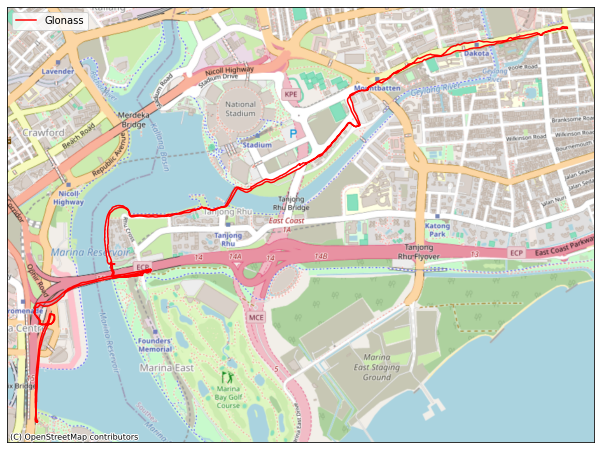

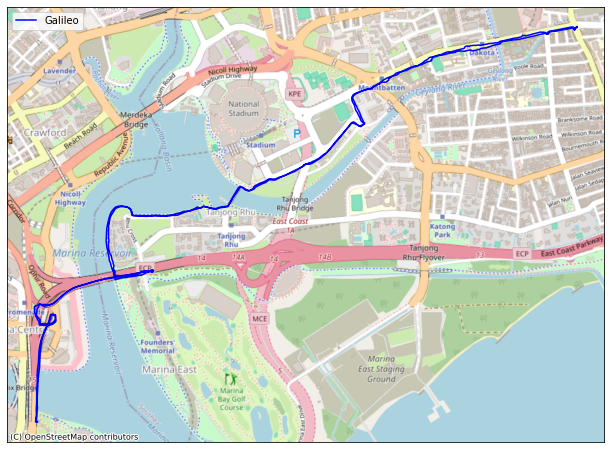

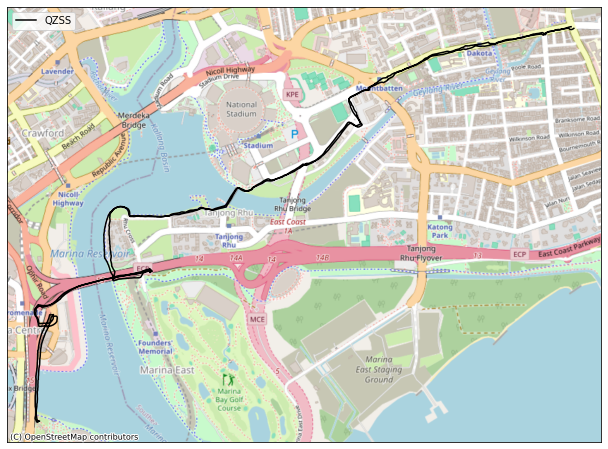

In [37]:
def plot_map(df, color, label):
    plt.figure(figsize=(15, 8))
    plt.plot(df['longitude'], df['latitude'], color=color, label=label)
    ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    plt.legend()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    plt.show()
    
plot_map(glonass_df, 'red', 'Glonass')
plot_map(galileo_df, 'blue', 'Galileo')
plot_map(qzss_df, 'black', 'QZSS')

In [27]:
desc_glonass_df = glonass_df['distance_to_route'].describe().to_frame()
desc_glonass_df.columns = ['Glonass']

desc_galileo_df = galileo_df['distance_to_route'].describe().to_frame()
desc_galileo_df.columns = ['Galileo']

desc_qzss_df = qzss_df['distance_to_route'].describe().to_frame()
desc_qzss_df.columns = ['QZSS']

merged_desc = pd.concat([desc_glonass_df, desc_galileo_df, desc_qzss_df], axis=1)
merged_desc.to_csv('/tmp/merged_desc.csv')

print(merged_desc)

           Glonass      Galileo         QZSS
count  4578.000000  4899.000000  4377.000000
mean      8.350552     6.705224     8.113881
std       7.256513     5.388914     7.286252
min       0.002431     0.001662     0.002440
25%       2.919420     2.910239     2.701281
50%       6.940325     5.456055     6.044185
75%      11.699260     8.832804    10.924129
max      46.822614    33.622118    42.930495


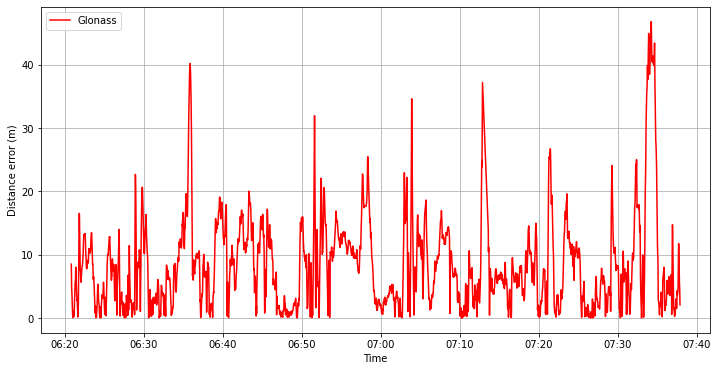

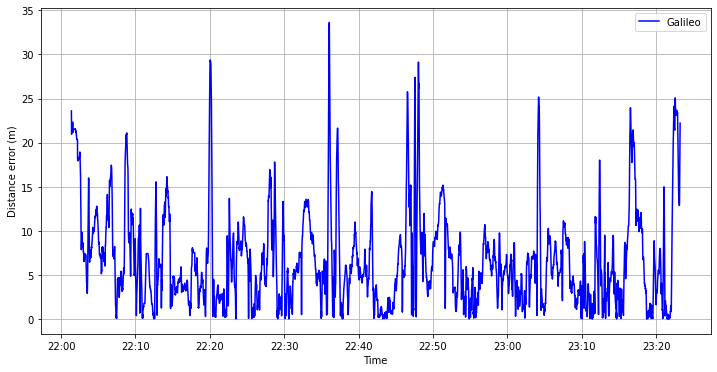

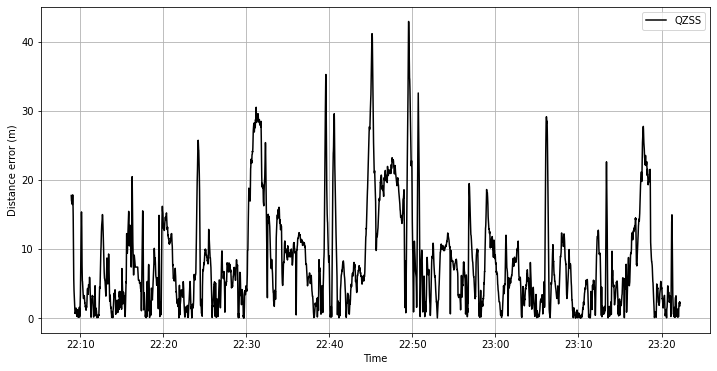

In [31]:
def plot_error(df, color, label):
    plt.figure(figsize=(12, 6))
    plt.plot(df['time'], df['distance_to_route'], color=color, label=label)
    plt.xlabel('Time')
    plt.ylabel('Distance error (m)')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.show()
    
plot_error(glonass_df, 'red', 'Glonass')
plot_error(galileo_df, 'blue', 'Galileo')
plot_error(qzss_df, 'black', 'QZSS')

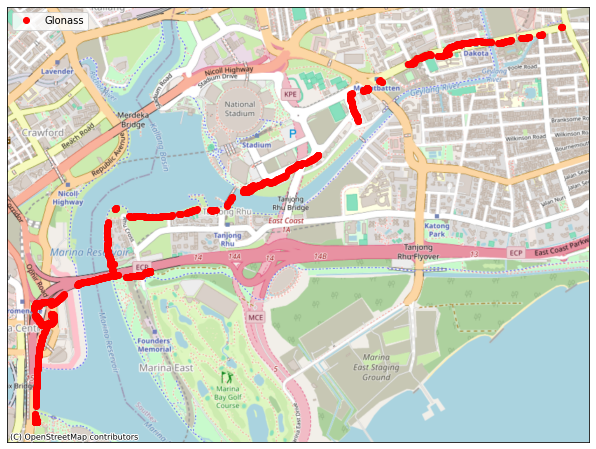

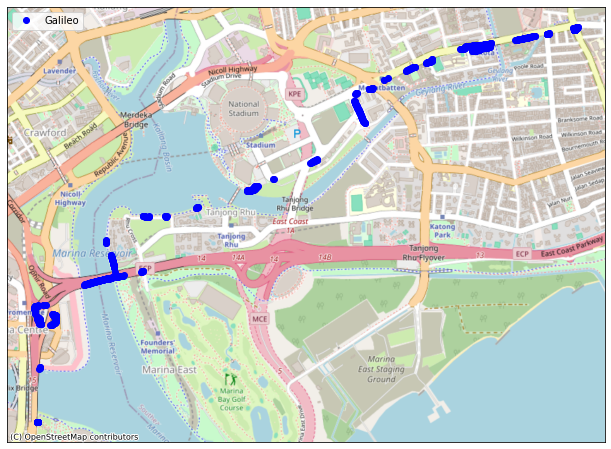

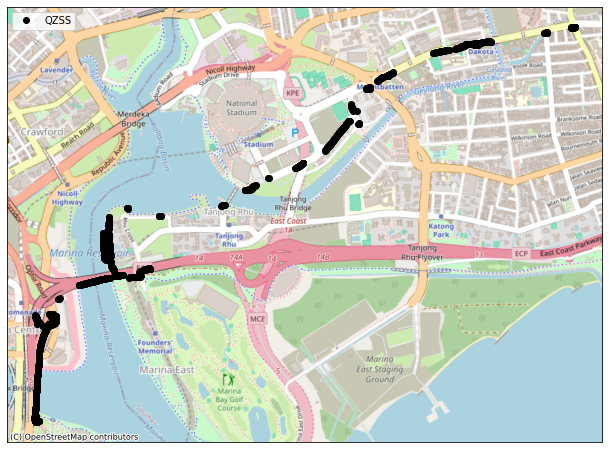

In [42]:
def plot_error_map(df, color, label):
    plt.figure(figsize=(15, 8))
    plt.plot(df['longitude'], df['latitude'], 'o', color=color, label=label)
    ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    plt.legend()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    plt.show()

plot_error_map(glonass_df[glonass_df['distance_to_route'] > 10], 'red', 'Glonass')
plot_error_map(galileo_df[galileo_df['distance_to_route'] > 10], 'blue', 'Galileo')
plot_error_map(qzss_df[qzss_df['distance_to_route'] > 10], 'black', 'QZSS')

In [32]:
glonass_df = get_total_distance(glonass_df)
glonass_df.iloc[-1]['accumulated_distance']

13320.220223368478

In [33]:
galileo_df = get_total_distance(galileo_df)
galileo_df.iloc[-1]['accumulated_distance']

13286.92032377833

In [34]:
qzss_df = get_total_distance(qzss_df)
qzss_df.iloc[-1]['accumulated_distance']

13192.221451193416